In [118]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [119]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Create SQLite engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [120]:
# Get table columns from database to inspect elements
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])
    
print("-------------------")

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [121]:
# Create last date variable and find prev year (365 days before last_date)
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
last_date = '2017-08-23'
print(prev_year)

2016-08-23


In [122]:
# Filter Query by date constraints and order by descending to plot
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_year).\
    filter(Measurement.date <= last_date).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])

df.sort_values(by=['date'])

df['date'] = pd.to_datetime(df['date'])

df = df.rename(columns={'date': 'Date'})

df.set_index('Date', inplace=True, )

df = df.rename(columns={'prcp': 'Precipitation'})

df.head()


,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


In [123]:
# Query Measurement table to inspect data
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


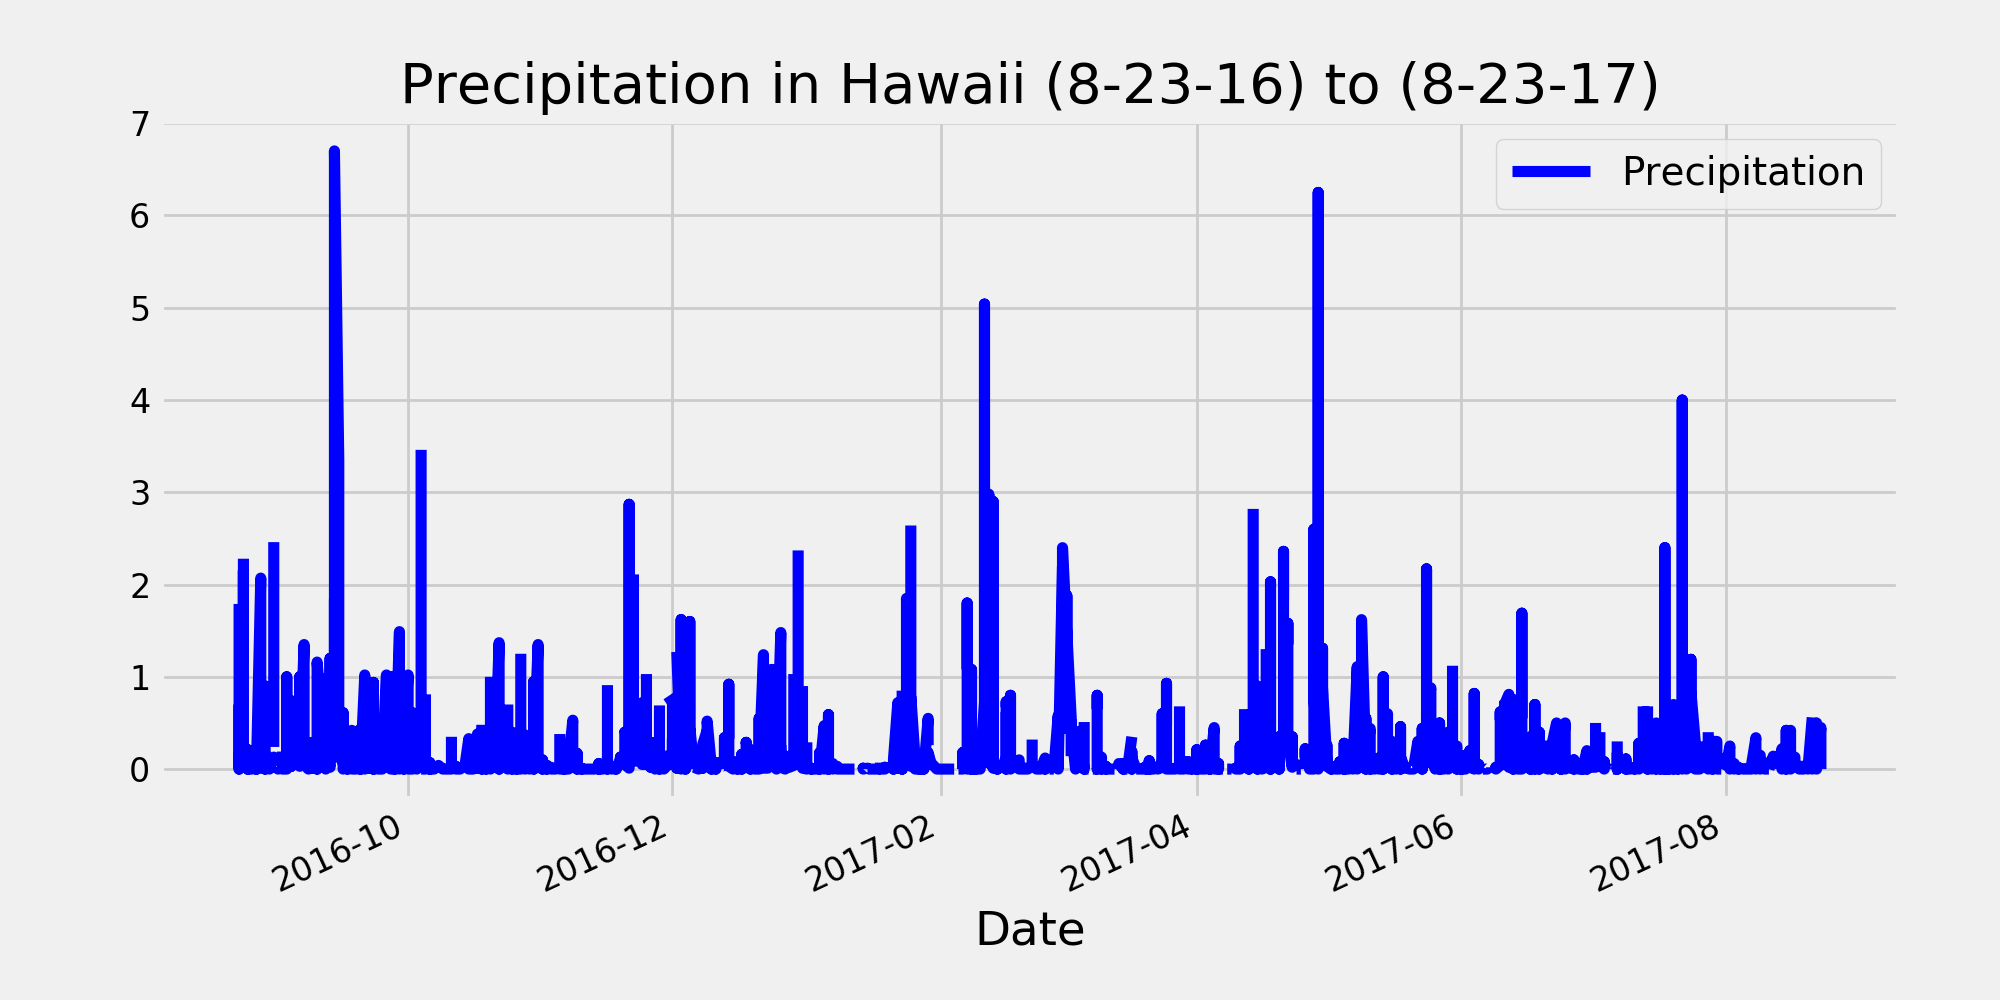

In [124]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,5), sort_columns=True, rot=25, fontsize=12, grid=True, use_index=True, 
       title='Precipitation in Hawaii (8-23-16) to (8-23-17)', legend=True, color="blue")


In [125]:
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [126]:
# Query station table
engine.execute('SELECT * FROM station LIMIT 11').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [127]:
# How many stations are available in this dataset?
station_count = session.query(func.count(Station.name)).all()
station_count

[(9)]

In [128]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.prcp)).\
            filter(Measurement.station==Station.station).group_by(Measurement.station).\
            order_by(func.count(Measurement.prcp).desc()).all()
station_activity

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

In [129]:
# View frist tuple in query variable (most active station)
station_activity[0]

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [130]:
# Declare most active station w/ station name
most_active_station = station_activity[0][0]
most_active_name = station_activity[0][1]
print(most_active_station)

USC00519281


In [131]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active_station).\
    filter(Measurement.date >= prev_year, Measurement.date <= last_date).all()
most_active_stats



[(59.0, 83.0, 73.10795454545455)]

In [132]:
# query temp obs for most active station
most_active_temp = session.query(Measurement.tobs).\
    filter(Measurement.station==most_active_station).\
    filter(Measurement.date >= prev_year, Measurement.date <= last_date).all()
most_active_temp

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

In [133]:
# Create DF with most active station's temp data
df2 = pd.DataFrame(most_active_temp)
df2["tobs"].count()
df2
temps = df2["tobs"].tolist()
#temps

<IPython.core.display.Javascript object>


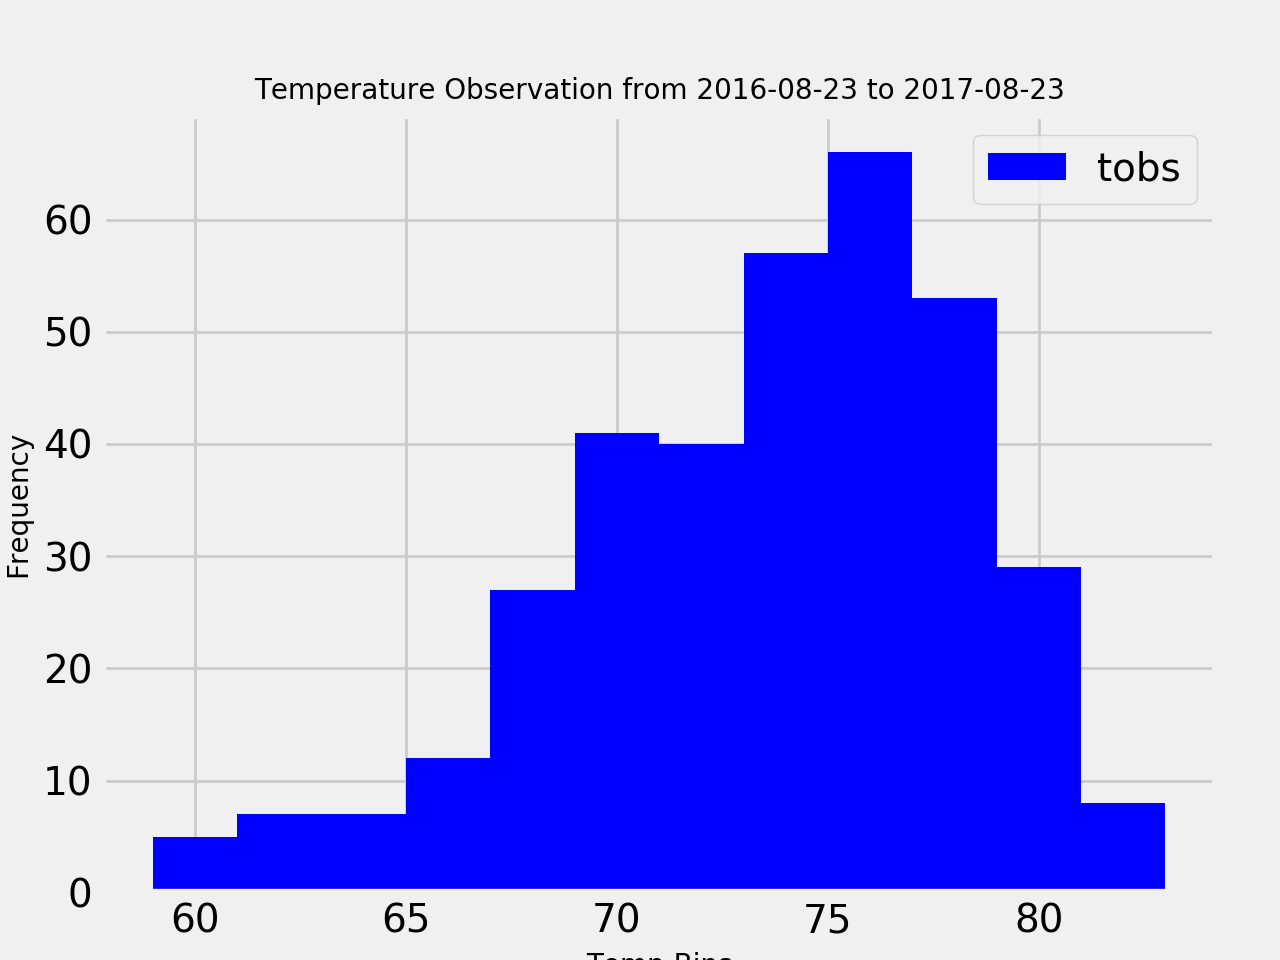

In [135]:
plt.hist(temps, bins=12, color='blue')

plt.title("Temperature Observation from 2016-08-23 to 2017-08-23", fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xlabel("Temp Bins", fontsize=10)
labels = ['tobs']
plt.legend(labels)

plt.show()

In [136]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date, Measurement.date <= end_date).all()

    temp_list = []
    for result in results:
        temp_list.append(result[0])
        temp_list.append(result[1])
        temp_list.append(result[2])
        
    return temp_list
        
print(calc_temps('2012-02-28', '2012-03-05'))

[62.0, 69.57142857142857, 74.0]


In [137]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(prev_year, last_date))

[58.0, 74.59058295964125, 87.0]


In [138]:
test_bar = calc_temps(prev_year, last_date)
test_bar

[58.0, 74.59058295964125, 87.0]

<IPython.core.display.Javascript object>


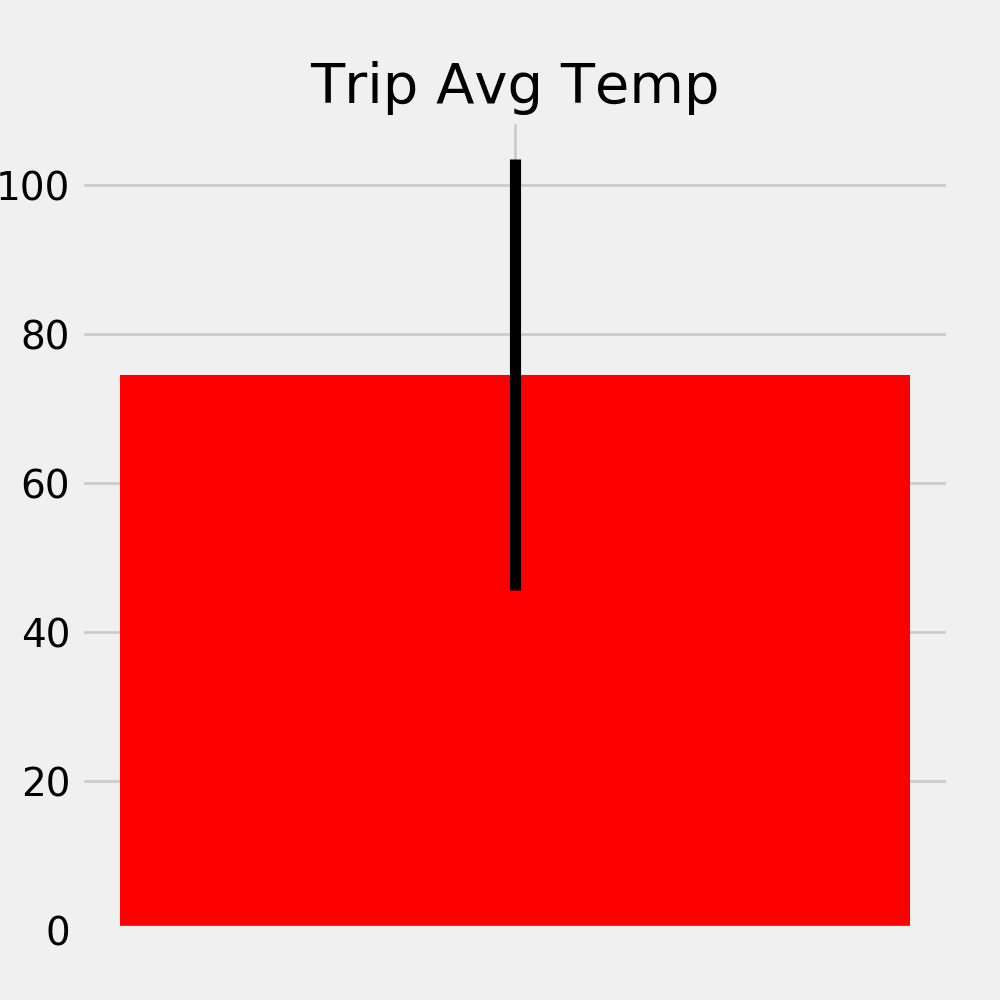

In [139]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,5))                                                   
plt.bar(1, test_bar[1], yerr=(test_bar[2] - test_bar[0]), tick_label='', color='red')
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
plt.show()

In [140]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prcp = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2016-10-27', Measurement.date <= '2016-11-04', Measurement.station == Station.station).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
station_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.379999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.7000000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.67),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.29000000000000004),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.29000000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.27),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [141]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-10")

[(62.0, 69.74137931034483, 77.0)]

In [163]:
# code to strip dates and create date variables to iterate over in query loop
start_date = '2017-01-10'
end_date = '2017-01-17'

split_start = start_date.split('-')
split_end = end_date.split('-')

start_md = split_start[1] + '-' + split_start[2]
end_md = split_end[1] + '-' + split_end[2]

start_mon = split_start[1]
end_mon = split_end[1]

start_d = start_md.split('-')
start_day = int(start_d[1])

end_d = end_md.split('-')
end_day = int(end_d[1])

days_btw = end_day - start_day
days_btw

firstd = dt.date(int(split_start[0]), int(split_start[1]), int(split_start[2]))
lastd = dt.date(int(split_end[0]), int(split_end[1]), int(split_end[2]))

days_btw


7

In [164]:
#create list of dates between trip start and end dates
deetz = []
while firstd <= lastd:
    deetz.append(firstd)
    firstd += dt.timedelta(days=1)
print(deetz[0])

2017-01-10


In [144]:
#loop through dates and pull min, max, avg data and append to list
i = 0 
trip_normalz = []

while i < days_btw:
    results = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(func.strftime("%m-%d", Measurement.date) == func.strftime("%m-%d", deetz[i])).all()
    trip_normalz.append(results)
    i += 1
trip_normalz   

[[('2015-01-10', 62.0, 69.74137931034483, 77.0)],
 [('2017-01-11', 57.0, 67.3103448275862, 78.0)],
 [('2017-01-12', 57.0, 67.4074074074074, 81.0)],
 [('2013-01-13', 57.0, 67.25454545454545, 77.0)],
 [('2017-01-14', 58.0, 69.52631578947368, 77.0)],
 [('2017-01-15', 56.0, 69.31372549019608, 78.0)],
 [('2017-01-16', 54.0, 68.62962962962963, 80.0)]]

In [156]:
#test code
results = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(func.strftime("%m-%d", Measurement.date) == func.strftime("%m-%d", deetz[0])).all()
results

i = 0
deets = ["01-10", "01-11", "01-12", "01-13", "01-14", "01-15", "01-16", "01-17"]
normals = []
while i < days_btw:
    normals.append(daily_normals(deets[i]))
    i += 1
normals 

[[(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)],
 [(57.0, 67.25454545454545, 77.0)],
 [(58.0, 69.52631578947368, 77.0)],
 [(56.0, 69.31372549019608, 78.0)],
 [(54.0, 68.62962962962963, 80.0)]]

In [147]:
# WOOOOO!! I got pretty lost on this one... haha please let me know if there is a better way to do this!
final = [trip_normalz[0] + trip_normalz[1] + trip_normalz[2] + trip_normalz[3] + trip_normalz[4] + trip_normalz[5] + trip_normalz[6]]
finalz = final[0]
finalz

[('2015-01-10', 62.0, 69.74137931034483, 77.0),
 ('2017-01-11', 57.0, 67.3103448275862, 78.0),
 ('2017-01-12', 57.0, 67.4074074074074, 81.0),
 ('2013-01-13', 57.0, 67.25454545454545, 77.0),
 ('2017-01-14', 58.0, 69.52631578947368, 77.0),
 ('2017-01-15', 56.0, 69.31372549019608, 78.0),
 ('2017-01-16', 54.0, 68.62962962962963, 80.0)]

In [148]:
# Create Final DataFrame for data
df3 = pd.DataFrame.from_records(finalz, columns=["Date", "TMin", "TAvg", "TMax"])
df_final = df3.set_index("Date")
df_final

,TMin,TAvg,TMax
Date,,,
2015-01-10,62.0,69.741379,77.0
2017-01-11,57.0,67.310345,78.0
2017-01-12,57.0,67.407407,81.0
2013-01-13,57.0,67.254545,77.0
2017-01-14,58.0,69.526316,77.0
2017-01-15,56.0,69.313725,78.0
2017-01-16,54.0,68.629630,80.0


<IPython.core.display.Javascript object>


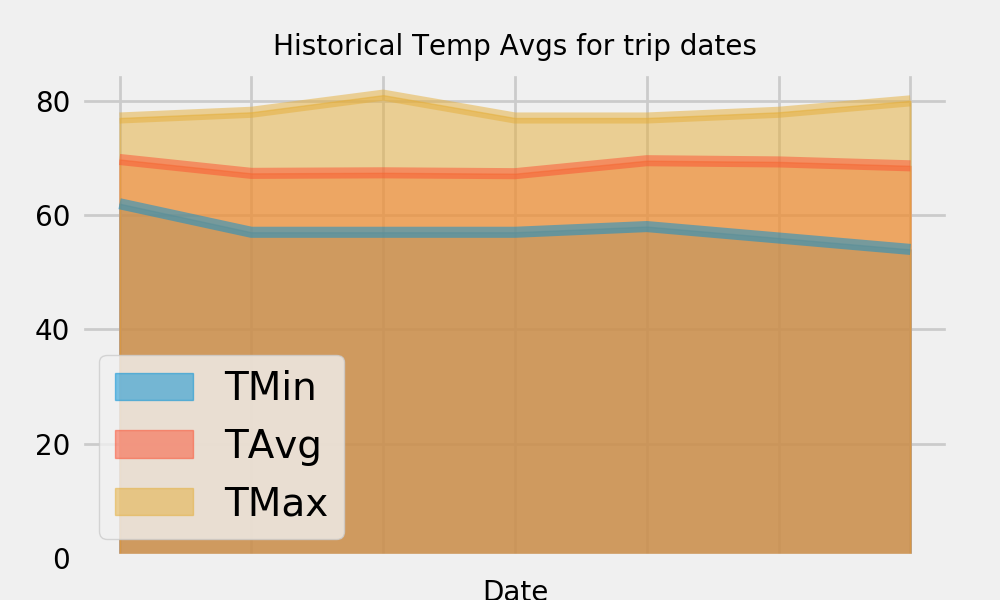

In [157]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_final.plot(figsize=(5,3), kind="area", stacked=False,
              grid=True, use_index=True, rot=45, fontsize=10,
              sort_columns=True, legend=True)

plt.xlabel('Date', fontsize=10)
plt.title("Historical Temp Avgs for trip dates",fontsize=10)
plt.show()


<IPython.core.display.Javascript object>


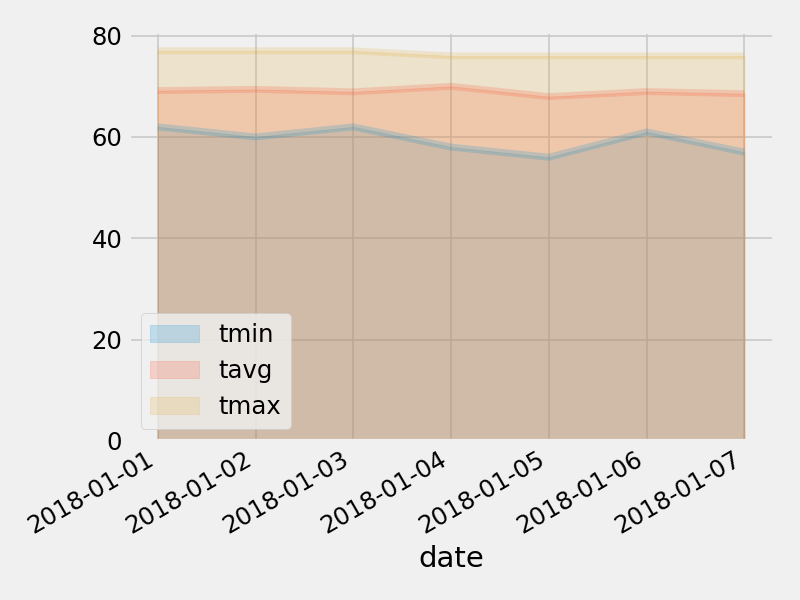

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
